In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
import cv2
import numpy as np
from tensorflow.keras.layers import (Conv2D, MaxPool2D, Dense, Flatten, InputLayer,BatchNormalization,
                                     Input,Layer,Dropout,Resizing,Rescaling,RandomRotation,RandomFlip,
                                     RandomContrast,Add,MaxPooling2D,Activation,GlobalAveragePooling2D)
from tensorflow.keras.models import Model
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy,CategoricalCrossentropy,SparseCategoricalCrossentropy
from tensorflow.keras.metrics import (BinaryAccuracy , FalsePositives,FalseNegatives,TruePositives,
                                      TrueNegatives,Precision,Recall,AUC,CategoricalAccuracy,
                                      TopKCategoricalAccuracy)
from tensorflow.keras.callbacks import Callback,CSVLogger,EarlyStopping,ModelCheckpoint,ReduceLROnPlateau,TensorBoard
from tensorflow.keras.regularizers import L1,L2
from tensorflow.image import (flip_left_right,random_flip_up_down,rot90,
                              adjust_brightness,random_saturation,central_crop,
                              adjust_saturation,crop_to_bounding_box,pad_to_bounding_box)


In [ ]:
train_dic = "/kaggle/input/bifors-images-dataset/biofors_img"
CONFIGURATION = {
    "BATCH_SIZE": 32,
    "IMG_SIZE": 256,
    "LEARNING_RATE": 1e-3,

    "N_EPOCHS": 20,
    "N_FILTERS": 6,
    "KERNEL_SIZE": 3,
    "N_STRIDES": 1,
    "POOL_SIZE": 2,
    "N_DENSE_1": 1024,
    "N_DENSE_2": 128,
    "NUM_CLASSES": 4,
    "PATCH_SIZE": 16,
    "PROJ_DIM": 768,
    "CLASS_NAMES": ['BlotGel','FACS','Macroscopy','Microscopy'],
}

In [ ]:
train_data = tf.keras.utils.image_dataset_from_directory(
    train_dic,
    labels='inferred',
    label_mode='categorical',
    class_names=CONFIGURATION["CLASS_NAMES"],
    color_mode='rgb',
    batch_size=CONFIGURATION["BATCH_SIZE"],
    image_size=(CONFIGURATION["IMG_SIZE"], CONFIGURATION["IMG_SIZE"]),
    shuffle=True,
    seed=99,
)

Found 2477 files belonging to 4 classes.


In [ ]:
train_data = (
    train_data.prefetch(tf.data.AUTOTUNE)
)

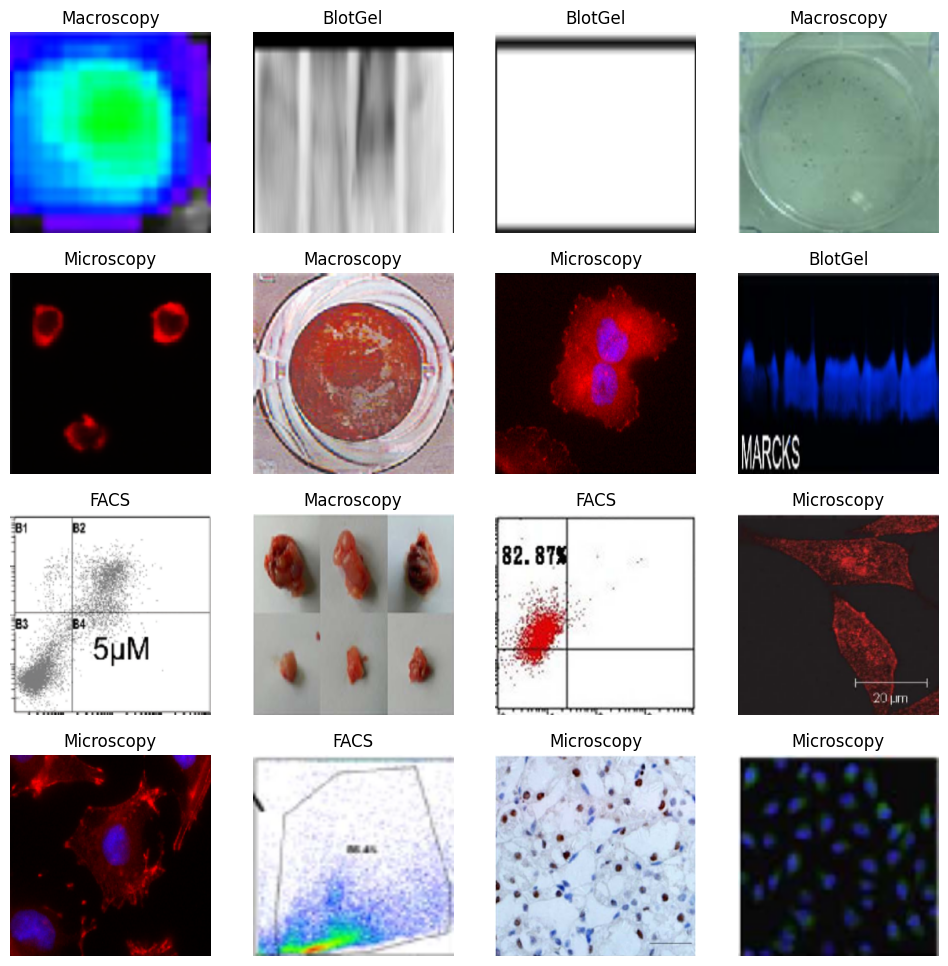

In [ ]:
plt.figure(figsize = (12,12))
for images , label in train_data.take(1):
  for i in range(16):
    ax = plt.subplot(4,4,i+1)
    plt.imshow(images[i]/255.)
    plt.title(CONFIGURATION["CLASS_NAMES"][tf.argmax(label[i],axis = 0).numpy()])
    plt.axis("off")

In [ ]:
resize_rescale_layer = Sequential([
    Resizing(CONFIGURATION["IMG_SIZE"], CONFIGURATION["IMG_SIZE"]),
    Rescaling(1./255),
])

In [ ]:
class CustomConv2D(Layer):
  def __init__(self, n_filters, kernel_size, n_strides, padding = 'valid'):
    super(CustomConv2D, self).__init__(name = 'custom_conv2d')

    self.conv = Conv2D(
        filters = n_filters,
        kernel_size = kernel_size,
        activation = 'relu',
        strides = n_strides,
        padding = padding)

    self.batch_norm = BatchNormalization()

  def call(self, x, training = True):

    x = self.conv(x)
    x = self.batch_norm(x, training=training)

    return x

In [ ]:
class ResidualBlock(Layer):
  def __init__(self, n_channels, n_strides = 1):
    super(ResidualBlock, self).__init__(name = 'res_block')

    self.dotted = (n_strides != 1)

    self.custom_conv_1 = CustomConv2D(n_channels, 3, n_strides, padding = "same")
    self.custom_conv_2 = CustomConv2D(n_channels, 3, 1, padding = "same")

    self.activation = Activation('relu')

    if self.dotted:
      self.custom_conv_3 = CustomConv2D(n_channels, 1, n_strides)

  def call(self, input, training):

    x = self.custom_conv_1(input,training=training)
    x = self.custom_conv_2(x, training=training)

    if self.dotted:
      x_add = self.custom_conv_3(input, training=training)
      x_add = Add()([x, x_add])
    else:
      x_add = Add()([x, input])

    return self.activation(x_add)


In [ ]:
class ResNet34(Model):
  def __init__(self,):
    super(ResNet34, self).__init__(name = 'resnet_34')

    self.conv_1 = CustomConv2D(64, 7, 2, padding = 'same')
    self.max_pool = MaxPooling2D(3,2)

    self.conv_2_1 = ResidualBlock(64)
    self.conv_2_2 = ResidualBlock(64)
    self.conv_2_3 = ResidualBlock(64)

    self.conv_3_1 = ResidualBlock(128, 2)
    self.conv_3_2 = ResidualBlock(128)
    self.conv_3_3 = ResidualBlock(128)
    self.conv_3_4 = ResidualBlock(128)

    self.conv_4_1 = ResidualBlock(256, 2)
    self.conv_4_2 = ResidualBlock(256)
    self.conv_4_3 = ResidualBlock(256)
    self.conv_4_4 = ResidualBlock(256)
    self.conv_4_5 = ResidualBlock(256)
    self.conv_4_6 = ResidualBlock(256)

    self.conv_5_1 = ResidualBlock(512, 2)
    self.conv_5_2 = ResidualBlock(512)
    self.conv_5_3 = ResidualBlock(512)

    self.global_pool = GlobalAveragePooling2D()

    self.fc_3 = Dense(CONFIGURATION["NUM_CLASSES"], activation = None)

  def call(self, x, training = True):
    x = self.conv_1(x)
    x = self.max_pool(x)

    x = self.conv_2_1(x, training=training)
    x = self.conv_2_2(x, training=training)
    x = self.conv_2_3(x, training=training)

    x = self.conv_3_1(x, training=training)
    x = self.conv_3_2(x, training=training)
    x = self.conv_3_3(x, training=training)
    x = self.conv_3_4(x, training=training)

    x = self.conv_4_1(x, training=training)
    x = self.conv_4_2(x, training=training)
    x = self.conv_4_3(x, training=training)
    x = self.conv_4_4(x, training=training)
    x = self.conv_4_5(x, training=training)
    x = self.conv_4_6(x, training=training)

    x = self.conv_5_1(x, training=training)
    x = self.conv_5_2(x, training=training)
    x = self.conv_5_3(x, training=training)

    x = self.global_pool(x)

    return self.fc_3(x)

In [ ]:
resnet_34 = ResNet34()
resnet_34(tf.zeros((1,224,224,3)), training = False)
resnet_34.summary()

Model: "resnet_34"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ custom_conv2d (CustomConv2D)    │ ?                      │         9,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ res_block (ResidualBlock)       │ ?                      │        74,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ res_block (ResidualBlock)       │ ?                      │        74,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ res_block (ResidualBlock)       │ ?                      │        74,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ res_block (ResidualBlock)       │ ?                      │       231,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ res_block (ResidualBlock)       │ ?                      │       296,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ res_block (ResidualBlock)       │ ?                      │       296,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ res_block (ResidualBlock)       │ ?                      │       296,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ res_block (ResidualBlock)       │ ?                      │       921,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ res_block (ResidualBlock)       │ ?                      │     1,182,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ res_block (ResidualBlock)       │ ?                      │     1,182,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ res_block (ResidualBlock)       │ ?                      │     1,182,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ res_block (ResidualBlock)       │ ?                      │     1,182,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ res_block (ResidualBlock)       │ ?                      │     1,182,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ res_block (ResidualBlock)       │ ?                      │     3,677,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ res_block (ResidualBlock)       │ ?                      │     4,723,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ res_block (ResidualBlock)       │ ?                      │     4,723,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ ?                      │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,312,260 (81.30 MB)

 Trainable params: 21,295,236 (81.23 MB)

 Non-trainable params: 17,024 (66.50 KB)

In [ ]:
loss_function = CategoricalCrossentropy(from_logits=True)

In [ ]:
matric = [SparseCategoricalCrossentropy(name="accuracy"),TopKCategoricalAccuracy(k = 2,name = "top_k_accuracy")]

In [ ]:
resnet_34.compile(
    optimizer = Adam(learning_rate = CONFIGURATION['LEARNING_RATE']),
    loss = loss_function,
    metrics = ['accuracy']
)

In [ ]:
history = resnet_34.fit(
    train_data,
    epochs = 25,
    verbose = 1
)

Epoch 1/25
78/78 ━━━━━━━━━━━━━━━━━━━━ 14s 176ms/step - accuracy: 0.8131 - loss: 0.5288
Epoch 2/25
78/78 ━━━━━━━━━━━━━━━━━━━━ 14s 176ms/step - accuracy: 0.8460 - loss: 0.4079
Epoch 3/25
78/78 ━━━━━━━━━━━━━━━━━━━━ 14s 176ms/step - accuracy: 0.8719 - loss: 0.3342
Epoch 4/25
78/78 ━━━━━━━━━━━━━━━━━━━━ 14s 178ms/step - accuracy: 0.8696 - loss: 0.3080
Epoch 5/25
78/78 ━━━━━━━━━━━━━━━━━━━━ 14s 177ms/step - accuracy: 0.8725 - loss: 0.3155
Epoch 6/25
78/78 ━━━━━━━━━━━━━━━━━━━━ 14s 178ms/step - accuracy: 0.9191 - loss: 0.2382
Epoch 7/25
78/78 ━━━━━━━━━━━━━━━━━━━━ 14s 178ms/step - accuracy: 0.9174 - loss: 0.2232
Epoch 8/25
78/78 ━━━━━━━━━━━━━━━━━━━━ 14s 179ms/step - accuracy: 0.8987 - loss: 0.2708
Epoch 9/25
78/78 ━━━━━━━━━━━━━━━━━━━━ 14s 179ms/step - accuracy: 0.9029 - loss: 0.2294
Epoch 10/25
78/78 ━━━━━━━━━━━━━━━━━━━━ 14s 179ms/step - accuracy: 0.9144 - loss: 0.2296
Epoch 11/25
78/78 ━━━━━━━━━━━━━━━━━━━━ 14s 179ms/step - accuracy: 0.9221 - loss: 0.2180
Epoch 12/25
78/78 ━━━━━━━━━━━━━━━━━━━━ 14

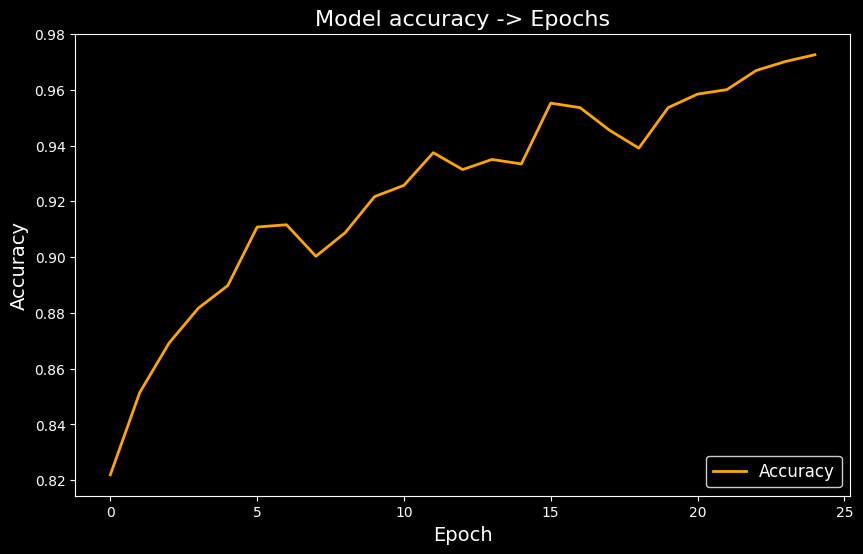

In [ ]:
import matplotlib as mpl

# Increase plot size and change to dark mode
plt.figure(figsize=(10, 6))
plt.style.use('dark_background')

# Plot accuracy
plt.plot(history.history['accuracy'], linewidth=2, color='orange')  # Change color here

# Title and labels with custom font color
plt.title('Model accuracy -> Epochs', fontsize=16, color='white')  # Change color here
plt.xlabel('Epoch', fontsize=14, color='white')  # Change color here
plt.ylabel('Accuracy', fontsize=14, color='white')  # Change color here
plt.legend(['Accuracy'], fontsize=12, loc='lower right', facecolor='black', edgecolor='white')  # Change color here

# Set the color of the tick labels
plt.gca().tick_params(axis='x', colors='white')  # Change color here
plt.gca().tick_params(axis='y', colors='white')  # Change color here

# Show plot
plt.show()


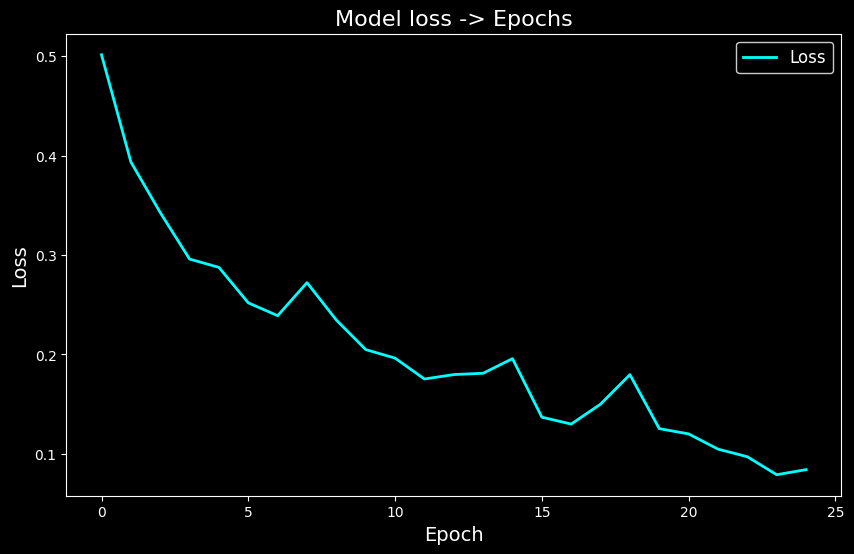

In [ ]:

plt.figure(figsize=(10, 6))
plt.style.use('dark_background')

plt.plot(history.history['loss'], linewidth=2, color='cyan')

plt.title('Model loss -> Epochs', fontsize=16, color='white')
plt.xlabel('Epoch', fontsize=14, color='white')
plt.ylabel('Loss', fontsize=14, color='white')
plt.legend(['Loss'], fontsize=12, loc='upper right', facecolor='black', edgecolor='white')


plt.gca().tick_params(axis='x', colors='white')
plt.gca().tick_params(axis='y', colors='white')


plt.show()

In [ ]:
resnet_34.evaluate(train_data)

78/78 ━━━━━━━━━━━━━━━━━━━━ 9s 76ms/step - accuracy: 0.9577 - loss: 0.1333


[0.13464488089084625, 0.9531691670417786]

In [ ]:
resnet_34.save('resnet_34_nirma.hdf5')